### In this model we will apply all our deep learning concepts to predict whether a person is introvert or extrovert.<br>
### Lets start with the notebook.


# Importing Libraries

In [151]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
import warnings
warnings.filterwarnings('ignore')
import keras
from keras import optimizers,regularizers
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.layers import Dense,Dropout
from scikeras.wrappers import KerasClassifier
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from tensorflow import random



# Reading Files

In [152]:
train=pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv',index_col="id")
test=pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv',index_col="id")
submission=pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')

In [153]:
#Checking the Sample submission
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert


In [154]:
print(submission.shape)

(6175, 2)


# Meet and Greet Data

In [155]:
#Checking Train and Test contents
#Train
train.head(3)

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert


In [156]:
#Test
test.tail(3)

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
id,,,,,,,
24696,2.0,No,4.0,3.0,No,9.0,7.0
24697,3.0,No,4.0,4.0,No,11.0,9.0
24698,NaN,Yes,1.0,1.0,Yes,1.0,0.0


In [157]:
#Checking Shapes
print(train.shape)
print(test.shape)

(18524, 8)
(6175, 7)


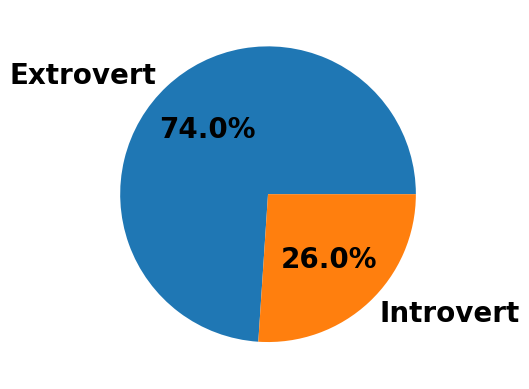

In [158]:
#Checking distribution of target data
plt.pie(train['Personality'].value_counts(),labels=train['Personality'].value_counts().keys(),autopct='%1.1f%%',textprops={'fontsize':20,'fontweight':'bold'})
plt.show()

In [159]:
#Checking Missing Values
missing_train=(train.isnull().sum()[train.isnull().sum()>0]).to_frame().rename(columns={0:'No of Missing Values'})
missing_train['% of Missing Values']=round((100*train.isnull().sum()[train.isnull().sum()>0]/len(train)),2)
missing_train.sort_values(by=['% of Missing Values'],ascending=False,inplace=True)
missing_train

,No of Missing Values,% of Missing Values
Stage_fear,1893,10.22
Going_outside,1466,7.91
Post_frequency,1264,6.82
Time_spent_Alone,1190,6.42
Social_event_attendance,1180,6.37
Drained_after_socializing,1149,6.20
Friends_circle_size,1054,5.69


In [160]:
missing_test=(test.isnull().sum()[test.isnull().sum()>0]).to_frame().rename(columns={0:'No of Missing Values'})
missing_test['% of Missing Values']=round((100*test.isnull().sum()[test.isnull().sum()>0]/len(test)),2)
missing_test.sort_values(by=['% of Missing Values'],ascending=False,inplace=True)
missing_test

,No of Missing Values,% of Missing Values
Stage_fear,598,9.68
Going_outside,466,7.55
Drained_after_socializing,432,7.00
Time_spent_Alone,425,6.88
Post_frequency,408,6.61
Social_event_attendance,397,6.43
Friends_circle_size,350,5.67


In [161]:
print(train.info())
print("\n")
print("*"*40)
print("\n")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB
None


****************************************


<class 'pandas.core.frame.DataFrame'>
Index: 6175 entries, 18524 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_A

In [162]:
train.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [163]:
train.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

# Data Preprocessing

<p> I am not comfortable combining the datasets for data preprocessing so I will be do preprocessing and cleaning for train and test simultaneously.</p>

In [164]:
cat_cols=train.select_dtypes(include=['object']).columns.tolist()
cat_cols.pop()
num_cols=train.select_dtypes(include=['number']).columns.tolist()
print(cat_cols)
print(num_cols)

['Stage_fear', 'Drained_after_socializing']
['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']


In [165]:
X=train.iloc[:,:-1]
y=train.iloc[:,-1]



In [166]:
print(X.head(5))

    Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
id                                                                        
0                0.0         No                      6.0            4.0   
1                1.0         No                      7.0            3.0   
2                6.0        Yes                      1.0            0.0   
3                3.0         No                      7.0            3.0   
4                1.0         No                      4.0            4.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  
id                                                                 
0                         No                 15.0             5.0  
1                         No                 10.0             8.0  
2                        NaN                  3.0             0.0  
3                         No                 11.0             5.0  
4                         No                 13.0             NaN 

In [167]:
print(y.head(5))

id
0    Extrovert
1    Extrovert
2    Introvert
3    Extrovert
4    Extrovert
Name: Personality, dtype: object


In [168]:
#Splitting the train and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1,shuffle=True)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(14819, 7) (14819,)
(3705, 7) (3705,)


### Label Encoding the Categorical Variable

In [169]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)


In [170]:
le_name_mapping=dict(zip(le.classes_,le.transform(le.classes_)))
le_name_mapping

{'Extrovert': 0, 'Introvert': 1}

In [171]:
print(y_train[:30])

[0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0]


In [172]:
print(y_test[:30])

[0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1]


### Creating Pipeline

In [173]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
cat_pipeline=make_pipeline(SimpleImputer(strategy="most_frequent"),OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan))


### Making the Column Transformer

In [174]:
ct=ColumnTransformer([("num",num_pipeline,num_cols),("cat",cat_pipeline,cat_cols)],verbose_feature_names_out=False,remainder='passthrough').set_output(transform='pandas')

In [175]:
X_train=pd.DataFrame(ct.fit_transform(X_train),columns=ct.get_feature_names_out())
X_test=pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

In [176]:
#Checking the Transformed dataframe shape
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(14819, 7) (14819,)
(3705, 7) (3705,)


In [177]:
X_train['Stage_fear']=X_train['Stage_fear'].astype(int)
X_test['Stage_fear']=X_test['Stage_fear'].astype(int)
X_train['Drained_after_socializing']=X_train['Drained_after_socializing'].astype(int)
X_test['Drained_after_socializing']=X_test['Drained_after_socializing'].astype(int)

In [178]:
#Checking the contents of Transformed Dataset
X_train.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_fear,Drained_after_socializing
id,,,,,,,
18489,-0.020671,-0.470224,-0.020538,-0.239615,0.724290,0,0
8928,-0.020671,-0.095264,-0.020538,1.222343,-0.353058,0,0
12380,-1.049754,-0.095264,1.496192,0.004045,-0.712174,0,0
3982,-0.706726,0.279695,-0.020538,0.978684,0.006058,0,0
17604,-1.049754,-0.095264,-0.526115,0.247705,0.006058,0,0


In [179]:
print(X_train.info())
print("\n")
print("*"*40)
print("\n")
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14819 entries, 18489 to 235
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           14819 non-null  float64
 1   Social_event_attendance    14819 non-null  float64
 2   Going_outside              14819 non-null  float64
 3   Friends_circle_size        14819 non-null  float64
 4   Post_frequency             14819 non-null  float64
 5   Stage_fear                 14819 non-null  int32  
 6   Drained_after_socializing  14819 non-null  int32  
dtypes: float64(5), int32(2)
memory usage: 810.4 KB
None


****************************************


<class 'pandas.core.frame.DataFrame'>
Index: 3705 entries, 13660 to 5890
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           3705 non-null   float64
 1   Social_even

In [180]:
#Checking the NUll Values
X_train.isnull().sum()

Time_spent_Alone             0
Social_event_attendance      0
Going_outside                0
Friends_circle_size          0
Post_frequency               0
Stage_fear                   0
Drained_after_socializing    0
dtype: int64

In [181]:
X_test.isnull().sum()

Time_spent_Alone             0
Social_event_attendance      0
Going_outside                0
Friends_circle_size          0
Post_frequency               0
Stage_fear                   0
Drained_after_socializing    0
dtype: int64

# Preparing Data for Modelling

### Setting the Initial Neural Network

In [182]:
seed=12
np.random.seed(seed)
random.set_seed(seed)

### Setting the Parameters Grid

In [183]:
params = {
'model__activation':['relu', 'sigmoid', 'tanh'],
'model__optimizer': ['adam', 'sgd', 'rmsprop'],
'batch_size':[10,20,30,40,50,100],
'model__dropout': [0.1,0.2,0.3,0.4,0.5],
'epochs':[100,200,300,400,500],
'model__neurons_1':[128,256,512],
'model__neurons_2':[64,16],
'model__neurons_3':[8,4]
}

In [184]:
def create_model(neurons_1,neurons_2,neurons_3,activation,optimizer,dropout):
    model = Sequential()
    model.add(Dense(input_dim=X_train.shape[1], units=neurons_1, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(units=neurons_2, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(units=neurons_3, activation=activation))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [185]:
model=KerasClassifier(model=create_model)

In [186]:
random_search=RandomizedSearchCV(estimator=model,param_distributions=params,cv=10,verbose=1,n_iter=5)

In [ ]:
random_search_result=random_search.fit(X_train,y_train)

print("Best Paramaters",random_search.best_params_)
print("Best Score",random_search.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Epoch 1/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7851 - loss: 0.5567
Epoch 2/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8925 - loss: 0.3444
Epoch 3/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2549
Epoch 4/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9434 - loss: 0.2149
Epoch 5/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9483 - loss: 0.2002
Epoch 6/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1962
Epoch 7/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9535 - loss: 0.1847
Epoch 8/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9535 - loss: 0.1855
Epoch 9/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9566 - loss: 0.1783
Epoch 10/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9523 - loss: 0.1878
Epoch 11/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.